In [10]:
%matplotlib inline
from __future__ import division
from copy import deepcopy
from gensim.models import KeyedVectors
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pyspan.bootstrapping as bts
from pyspan.config import *
from pyspan import excerpt_sampler as excs
from pyspan.synonyms import item_exclusions as item_ex

The signal calculations used to choose stimuli are saved to make the survey reproducible.

In [11]:
# Load data
df_crec = pickle.load(open("version_used_for_LoP_Synonyms_crec_signals-unigrams", 
                           "rb"))
df_debates = pickle.load(open("version_used_for_LoP_Synonyms_debates_signals-unigrams", 
                              "rb"))

In [12]:
# Create a new df containing only the words from the CRec data that
# "cross-validate" to the debate data
df = df_crec.join(df_debates, how = "inner", lsuffix = "_c", 
                  rsuffix = "_d")
cv = np.apply_along_axis(lambda i: df.loc[i]["dmetric_c"] * df.loc[i]["dmetric_d"] <= 0,
                         0, df.index)
ma = np.ma.masked_array(df.index, mask = cv)
df = df.loc[ma.compressed()]
df.sort_values(["dmetric_c"], inplace = True)

In [13]:
len(df)

1421

In [18]:
# And select the Republican signals from this new df
with open("words_repub.csv", "w") as wfh:
    wfh.write(",\n".join(df.loc[df["dmetric_c"] < 0].index))
# And the Democratic signals
with open("words_dem.csv", "w") as wfh:
    wfh.write(",\n".join(df.loc[df["dmetric_c"] > 0].index[::-1]))

This csv was manually annotated by an RA and one of the authors to contain synonyms for the words.

In [13]:
synd_long = pd.read_csv("words_dem-annotated.csv")
synd_long.columns = range(len(synd_long.columns))
synd_long = synd_long.loc[synd_long[1] != "-1"]

For each partisan word, select the subset of words that
- "Belong" to the associated party
- Cross-validate to the debates
- Don't have another meaning
- Are single words

Keep a running list of words to exclude so I only have to see ones I haven't seen before.

In [15]:
exclude = open("exclude", "r").read().split("\n")

Manually comb through the candidates and indicate if it should be added to the exclude list.

In [16]:
synd = deepcopy(synd_long)
for ix, row in zip(synd_long.index, synd_long.values):
    for i, word in enumerate(row):
        if not isinstance(word, basestring):
            assert np.isnan(word)
            synd.loc[ix][i] = ""
            continue
        if word not in df.index:
            synd.loc[ix][i] = ""
            continue
        if i == 0 and synd.loc[ix][i].strip():
            if df_crec.loc[word]["dmetric"] < 0:
                synd.loc[ix][i] = ""
        elif synd.loc[ix][0].strip() and synd.loc[ix][i].strip():
            try:
                if df_crec.loc[word]["dmetric"] > 0:
                    synd.loc[ix][i] = ""
                    continue
            except KeyError:
                synd.loc[ix][i] = ""
                continue
            s = " ".join((synd.loc[ix][0], word))
            if s in exclude or " ".join((s.split()[1], s.split()[0])) in exclude:
                synd.loc[ix][i] = ""
                continue
            val = raw_input(s)
            if val.strip():
                synd.loc[ix][i] = ""
                exclude.append(s)
    if ( (not synd.loc[ix][0]) or 
         (all([ not w for w in synd.loc[ix][range(1,i)] ]))
       ):
        synd = synd[synd.index != ix]
        continue
    vals = [ val for val in synd.loc[ix].values if val.strip() ]
    pad_width = len(row) - len(vals)
    synd.loc[ix] = np.pad(vals, (0, pad_width), "constant")

wealthy prosperous
comprehensive complete
wealth prosperity
workers employees
contribute give
values principles
assault attack
acknowledge recognize
fear terror
respond answer
profit gain
potentially possibly
glad happy
financial monetary
kinds types
end finish
criminal illegal
spoke talked


In [17]:
synr_long = pd.read_csv("words_repub-annotated.csv")
synr_long.columns = range(len(synr_long.columns))
synr_long = synr_long.loc[synr_long[1] != "-1"]

In [18]:
synr = deepcopy(synr_long)
for ix, row in zip(synr_long.index, synr_long.values):
    for i, word in enumerate(row):
        if not isinstance(word, basestring):
            assert np.isnan(word)
            synr.loc[ix][i] = ""
            continue
        if word not in df.index:
            synr.loc[ix][i] = ""
        if i == 0 and synr.loc[ix][i].strip():
            if df_crec.loc[word]["dmetric"] > 0:
                synr.loc[(ix,i)] = ""
                continue
        elif ( synr.loc[(ix,0)].strip() and 
               synr.loc[(ix,i)].strip() ):
            try:
                if df_crec.loc[word]["dmetric"] < 0:
                    synr.loc[(ix,i)] = ""
                    continue
            except KeyError:
                synr.loc[(ix,i)] = ""
                continue
            s = " ".join((synr.loc[ix][0], word))
            if s in exclude or " ".join((s.split()[1], s.split()[0])) in exclude:
                synr.loc[ix][i] = ""
                continue
            val = raw_input(s)
            if val.strip():
                synr.loc[ix][i] = ""
                exclude.append(s)
    if ( (not synr.loc[ix][0]) or 
         (all([ not w for w in synr.loc[ix][range(1,i)] ]))
       ):
        synr = synr[synr.index != ix]
        continue
    vals = [ val for val in synr.loc[ix].values if val.strip() ]
    pad_width = len(row) - len(vals)
    synr.loc[ix] = np.pad(vals, (0, pad_width), "constant")

reforms changes
terror fear
mom mother
prosperity wealth
recognize acknowledge
monetary financial
duty responsibility
principles values
finish end
walls barriers
announced indicated
excessive outrageous
conversation discussion
preserve maintain
fundamental basic


In [19]:
with open("exclude", "w") as wfh:
    wfh.write("\n".join(exclude))

In [20]:
synd.to_csv("synonyms_dem.csv")
synr.to_csv("synonyms_repub.csv")

In [21]:
synd = pd.read_csv("synonyms_dem.csv")
synr = pd.read_csv("synonyms_repub.csv")

In [22]:
synr_ = synr[["1","0"]]
synr_.columns = ["0","1"]
syns = pd.concat([synd, synr_])[["0","1"]]
syns.drop_duplicates(subset = ["0","1"], inplace = True)
# Remove ("wealthy", "prosperous") because we already have ("wealth", "prosperity")
syns = syns[syns["0"] != "wealthy"]
syns.reset_index(inplace = True)
syns.columns = ["index","D","R"]

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
syns.to_csv("synonyms.csv")

In [24]:
syns = pd.read_csv("synonyms.csv")

Look at the distribution of log odds in the new shortlists.

In [25]:
def get_log_odds(w, party):
    col = "dmetric"
    try:
        m = df_crec.loc[w][col]
        if party == "republican":
            m = -m
        return m
    except KeyError:
        return np.nan

(array([1., 2., 0., 1., 0., 2., 1., 9., 7., 3.]),
 array([-1.34200151, -1.20812921, -1.0742569 , -0.9403846 , -0.8065123 ,
        -0.67263999, -0.53876769, -0.40489539, -0.27102309, -0.13715078,
        -0.00327848]),
 <a list of 10 Patch objects>)

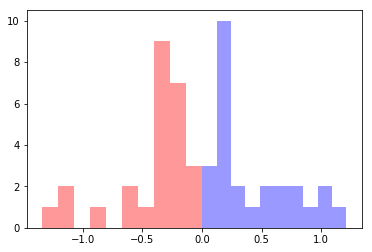

In [26]:
dwords = np.array(map(lambda w: get_log_odds(w, "democrat"), syns["D"]))
rwords = np.array(map(lambda w: get_log_odds(w, "democrat"), syns["R"]))
plt.hist(dwords, color = "b", alpha = .4)
plt.hist(rwords, color = "r", alpha = .4)

In [27]:
df_cis = pickle.load(open(bts.CONFINTS_FN, "rb"))

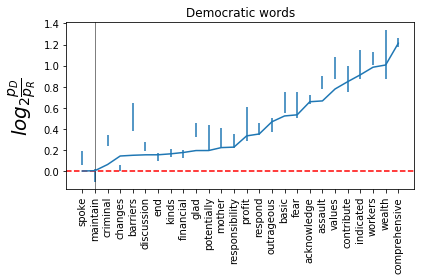

In [28]:
words_dt = syns["D"].values
words_dt = sorted(words_dt, key = lambda w: df_crec.loc[w]["dmetric"])
words = words_dt
n = len(words)
y = [ df_crec.loc[w]["dmetric"] for w in words ]
yerr = [ df_cis.loc[w][["lbound","ubound"]].values for w in words ]
yerr = np.array(yerr).T
yerr[0] = y - yerr[0]
yerr[1] = yerr[1] - y
plt.errorbar(range(n), y, yerr)
plt.xlim(*plt.xlim())
plt.xticks(range(n), words, rotation = 90)
plt.ylabel(r"$log_2\frac{p_D}{p_R}$", fontsize = 20)
plt.ylim(*plt.ylim())
ixs = [ ix for ix in range(n) if y[ix] - yerr[0,ix] < 0 ]

# Save "significance"
dconf = [""] * len(syns)
syns["D conf."] = dconf
for ix in ixs:
    plt.plot([ix,ix], plt.ylim(), "k", linewidth = .5)
    syns.loc[syns["D"] == words[ix],"D conf."] = "n.s."
plt.plot(plt.xlim(), [0,0], "r--")
plt.title("Democratic words")
plt.tight_layout()

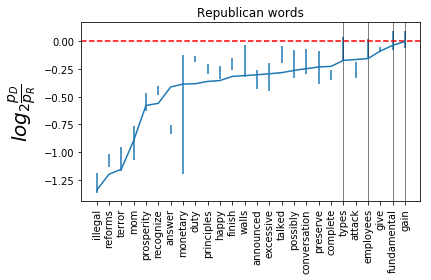

In [29]:
words_dd = syns["R"].values
words_dd = sorted(words_dd, key = lambda w: df_crec.loc[w]["dmetric"])
words = words_dd
n = len(words)
y = [ df_crec.loc[w]["dmetric"] for w in words ]
y = [ df_crec.loc[w]["dmetric"] for w in words ]
yerr = [ df_cis.loc[w][["lbound","ubound"]].values for w in words ]
yerr = np.array(yerr).T
yerr[0] = y - yerr[0]
yerr[1] = yerr[1] - y
plt.errorbar(range(n), y, yerr)
plt.xlim(*plt.xlim())
plt.xticks(range(n), words, rotation = 90)
plt.ylabel(r"$log_2\frac{p_D}{p_R}$", fontsize = 20)
plt.ylim(*plt.ylim())
ixs = [ ix for ix in range(n) if y[ix] + yerr[1,ix] > 0 ]

# Save "significance"
rconf = [""] * len(syns)
syns["R conf."] = rconf
for ix in ixs:
    plt.plot([ix,ix], plt.ylim(), "k", linewidth = .5)
    syns.loc[syns["R"] == words[ix],"R conf."] = "n.s."
plt.plot(plt.xlim(), [0,0], "r--")
plt.title("Republican words")
plt.tight_layout()

Add the cosine similarity of the pairs to the DataFrame.

In [30]:
word_vectors = KeyedVectors.load(paths["input_dir"] + "crec_w2v")

In [31]:
cossim = np.apply_along_axis(lambda a: word_vectors.similarity(*a), 1, syns[["D","R"]])

In [32]:
cossim_dist = pickle.load(open(paths["metrics_dir"] + "cos_sim-unigrams", "rb"))
cossim_dist = cossim_dist["cos_sim"]

In [33]:
cossim_qs = [ len(cossim_dist[cossim_dist < cs]) / len(cossim_dist) for cs in cossim ]

In [34]:
syns["cossim_quantiles"] = cossim_qs

In [35]:
syns = syns[["D","R","D conf.","R conf.","cossim_quantiles"]]
syns.to_csv("synonyms.csv")

In [36]:
syns = pd.read_csv("synonyms.csv")

Extract 10 sentences from the Congressional Record containing these words.

In [37]:
sampler = excs.Sampler(np.ravel(syns[["D","R"]].values))

Unigrams detected. Is this the correct mode?y


In [38]:
sampler.load_corpus()

In [8]:
sampler.get_excerpts(n = 10, fn = "excerpts_short")

In [39]:
excerpts = pickle.load(open("excerpts_short", "rb"))

Add synonym substitutions.

In [40]:
excerpts_ = deepcopy(excerpts)
for ix in syns.index:
    dword, rword = syns.loc[ix][["D","R"]]
    for excerpt in excerpts[dword]:
        excerpts_[rword] = np.append(excerpts_[rword],
                                     [excerpt.replace(dword, rword)])
    for excerpt in excerpts[rword]:
        excerpts_[dword] = np.append(excerpts_[dword],
                                     [excerpt.replace(rword, dword)])

In [41]:
with open("excerpts", "wb") as wfh:
    pickle.dump(excerpts_, wfh)

In [42]:
excerpts_ = pickle.load(open("excerpts", "rb"))

In [43]:
excerpts_untagged = list(chain(*excerpts_.values()))
np.random.shuffle(excerpts_untagged)
assert len(excerpts_untagged) == len(syns) * 2 * 20

Two RAs "cleaned" these excerpts (removed extra spaces, etc.). For the item-level exclusion procedure (pre-registered [here](https://osf.io/29yac)), I went through and consolidated these cleaned sentences.

In [ ]:
item_ex.process_raw()

Two sentences were sampled twice. Replace these in the processed csv.

In [24]:
o1, r1, o2, r2 = item_ex.replace_duplicates()

Unigrams detected. Is this the correct mode?y


And replace the relevant sentences manually in the processed csv. Also update the tag for the sentences with imputed word tag "CAN'T_ID" (couldn't be identified).

Tag sentences as original vs. substitutions

In [41]:
item_ex.tag_sentences()

Find the rows of the processed csv where the sentences wasn't identified as an original or a substitution, and manually annotate those.

In [46]:
proc = pd.read_csv("excerpts_processed.csv")
proc.loc[(proc["is_original"] == -1000) & (proc["is_substitution"] == -1000)]

,Unnamed: 0,Unnamed: 0.1,original,updated,words,is_original,is_substitution
37,37,37,MANUALLY CHANGED (see get_terms.ipynb),It is like trying to send an army into battle...,barriers,-1000,-1000
106,106,106,MANUALLY CHANGED (see get_terms.ipynb),This is an excessive burden.,excessive,-1000,-1000
254,254,254,I also want to show that it's not only in Orla...,I also want to show that it's not only in Orla...,complete,-1000,-1000
348,348,348,MANUALLY CHANGED (see get_terms.ipynb),This is an outrageous burden.,outrageous,-1000,-1000
932,932,932,MANUALLY CHANGED (see get_terms.ipynb),It is like trying to send an army into battle...,walls,-1000,-1000


And some last-minute sanity checks.

In [65]:
item_ex.check_processed()

In [29]:
item_ex.regroup_sentences()

Two annotators were each given the group1.csv and group2.csv, and saw these instructions:
    
*The csv file you've been emailed contains a list of 520 sentences. All of these sentences, or versions that are almost identical, were said on the floor of the U.S. House of Congress between 2012 and 2017.*

*For your task, assume that the scribe who has created the transcripts you are reading has made a few mistakes,. For example, they may have accidentally transcribed the wrong word here and there. In the sentences that follow, please indicate your judgment of the likelihood that such an error has been made.*

*In the "ratings" column, please put a number between 1 and 4, where*
- *1 means "I am almost sure this is the original text",*
- *2 means "I am not sure, but this is probably the original text",*
- *3 means "I am not sure, but this sentence probably contains at least one transcription error", and*
- *4 means "I am almost sure this sentence contains at least one transcription error".*

*Please rate every sentence, using only integers 1--4. Please do not discuss your answers with any of the other RAs. If you have any questions, reach out to me (Sabina).*

Use these ratings to implement the pre-registered criteria for item-level exclusion.

In [89]:
item_ex.items_to_exclude()

[array(['terror', 'fear'], dtype=object)]